### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [4]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import warnings
import torch   
import torchvision  
from torch import nn                                

### **THE POKEMON DATASET:**
- The dataset is a collection of Pokemon sprites obtained from [**PokemonDB**](https://pokemondb.net/sprites). I will download, extract and load the dataset. 

In [22]:
#@ GETTING THE DATASET: 
d2l.DATA_HUB["pokemon"] = (d2l.DATA_URL + 'pokemon.zip', 
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')          # Path to Dataset.
data_dir = d2l.download_extract("pokemon")                                      # Downloading and Extracting the Dataset. 
pokemon = torchvision.datasets.ImageFolder(data_dir)                            # Initializing DataLoader. 

- I will resize each image into 64X64 and normalize the data with 0.5 mean and 0.5 standard deviation. 

In [23]:
#@ PREPARING THE DATASET: 
batch_size = 256                                              # Initialization. 
transformer = torchvision.transforms.Compose([                # Initializing Compose Instance. 
              torchvision.transforms.Resize((64, 64)),        # Resizing Images. 
              torchvision.transforms.ToTensor(),              # Converting into Tensors. 
              torchvision.transforms.Normalize(0.5, 0.5)])    # Normalizing the Data. 
pokemon.transform = transformer                               # Transforming the Pokemon Dataset. 
data_iter = torch.utils.data.DataLoader(
            pokemon, batch_size=batch_size, shuffle=True, 
            num_workers=d2l.get_dataloader_workers())         # Initializing Data Iterations. 

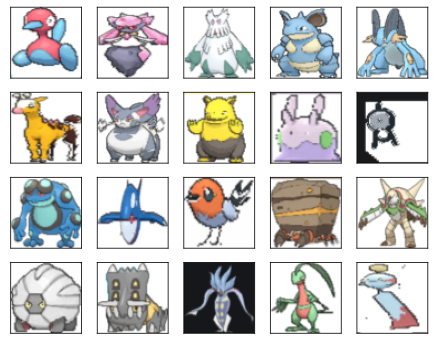

In [28]:
#@ VISUALIZING THE DATASET: 
warnings.filterwarnings("ignore")
d2l.set_figsize((5, 5))
for X, y in data_iter:
  imgs = X[0:20, :, :, :].permute(0, 2, 3, 1) / 2 + 0.5       # Getting Images. 
  d2l.show_images(imgs, num_rows=4, num_cols=5)               # Visualizing Images. 
  break

### **THE GENERATOR:**
- The Generator needs to map the noise variable to a RGB image. I will use transposed convolutional layer to enlarge the input image. The basic block of Generator contains a transposed convolution layer followed by the batch normalization and RELU activation function. 

In [31]:
#@ DEFINING THE GENERATOR:
class G_Block(nn.Module):                                                       # Initializing Generator. 
  def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, 
               padding=1, **kwargs):                                            # Initializing Constructor Function. 
    super(G_Block, self).__init__(**kwargs)
    self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels, 
                                           kernel_size, strides, padding, 
                                           bias=False)                          # Initializing Transposed Convolution Layer. 
    self.batch_norm = nn.BatchNorm2d(out_channels)                              # Initializing Batch Normalization Layer. 
    self.activation = nn.ReLU()                                                 # Initializing RELU Activation Layer. 
  
  def forward(self, X):                                                         # Forward Propagation Layer. 
    return self.activation(self.batch_norm(self.conv2d_trans(X)))               # Implementation of Layers. 
#@ INSPECTING THE IMPLEMENTATION: 
X = torch.zeros((2, 3, 16, 16))                                                 # Initializing Tensor. 
G_block = G_Block(20)                                                           # Implementation. 
G_block(X).shape                                                                # Inspecting Shape. 

torch.Size([2, 20, 32, 32])